Dask Approach to Non-SQL PTM Queries
--

v01: move away from classes, try to organize the computation 
primarily in dask.

-compare: Look more closely at particle distributions, try to 
understand why NB might be so low.

1. Are particles getting stuck somewhere? Zoom through the
   distributions.
2. Are any sources contributing a particularly small amount?


In [1]:
# There are some issues with memory usage. It seems
# (mostly based on github discussions) that with dask
# shuttling many large memory allocations around, memory
# gets fragmented and effectively lost. print_rusage()
# will report current memory usage, and the code in the
# next block changes malloc behavior to reduce 
# fragmentation.

import gc
import psutil
from distributed.utils import format_bytes
proc = psutil.Process()

def print_rusage():
    gc.collect()
    print(format_bytes(proc.memory_info().rss))
    #ru=resource.getrusage(resource.RUSAGE_SELF)
    #print(f"{ru.ru_maxrss/1000/1000.:.3f} GB maxrss")
    # That's saying that this process is using 55GB of RAM!?
    
print_rusage() # Starts 80MB

68.67 MB


In [2]:
import postproc_dask as post
import six
six.moves.reload_module(post)
post.config_malloc()

In [3]:
try:
    client.close()
except NameError:
    pass

In [4]:
import multiprocessing.popen_spawn_posix #  https://github.com/dask/distributed/issues/4168
import dask
import dask.dataframe as dd
import dask.bag as db

In [5]:
from dask.distributed import Client
client=Client(n_workers=1,threads_per_worker=1)
client.cluster

In [6]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [8]:
# Experiment level configuration -- small, all python native data.
# The 'new' run
cfg=dict(
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022b",
    sun_base_dir="/opt2/sfb_ocean/suntans/runs",
    ptm_output_interval=np.timedelta64(1,'h')
)
cfg['ptm_run_patt']=os.path.join(cfg['ptm_base_dir'],"chunk??","20??????")
cfg['sun_patt']=os.path.join(cfg['sun_base_dir'],"merged_022_20??????")

ptm_run_paths=glob.glob(cfg['ptm_run_patt'])
ptm_run_paths.sort()
cfg['ptm_run_paths']=ptm_run_paths

sun_paths=glob.glob(cfg['sun_patt'])
sun_paths.sort()
cfg['sun_paths']=sun_paths

In [9]:
# Load the grid into... grid
hydro_path=sun_paths[0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
ptm_ds.close()   

# distribute to workers ahead of time.
grid_d=client.scatter(grid)
cfg['grid_d']=grid_d # too far?

In [10]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=grid.smooth_matrix()

INFO:utils:61659/99089


In [11]:
six.moves.reload_module(post)

<module 'postproc_dask' from '/home/rusty/src/microplastic_sfbay/postprocess/postproc_dask.py'>

In [12]:
# Or could make this delayed and have it execute on each client?
load_data_d=client.scatter(post.get_load_data())
cfg['load_data_d']=load_data_d


In [13]:
def total_area(g):
    return g.cells_area().sum()

total_area_d=dask.delayed(total_area)(grid_d)
cfg['total_area_d']=total_area_d


In [14]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(sun_paths)


In [15]:
bc_ds_d=client.scatter(post.bc_ds(cfg=cfg))
cfg['bc_ds_d']=bc_ds_d

In [16]:
#criteria=dict(t_min=np.datetime64("2017-06-30 00:00"), # should be 08/30
#              t_max=np.datetime64("2017-07-01 00:00"), # should be 09/14
#              category='nonfiber',
#              z_below_surface_max=0.095,
#              age_max=np.timedelta64(10,'D'))


Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [17]:
areas=grid.cells_area()

six.moves.reload_module(post)    

<module 'postproc_dask' from '/home/rusty/src/microplastic_sfbay/postprocess/postproc_dask.py'>

In [18]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
manta.head()

,SampleID,SAMPLE LOCATION,DATE,TYPE,LAT START,LONG START,LAT END,LONG END,TOTAL DIST (M),START FLOW,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,CB-4-Manta-21Aug2017,CB4,2017-08-21 00:00:00,Manta,37.915567,-122.441217,37.941933,-122.419983,3473.323262,NaN,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,SPB3-Manta-21Aug2017,SPB3,2017-08-21 00:00:00,Manta,38.023072,-122.371583,38.042133,-122.321883,66678.222270,9113.0,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,SUB1-Manta-21Aug2017,SUB1,2017-08-21 00:00:00,Manta,38.107067,-122.056283,38.096533,-122.064917,1393.740434,128369.0,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,SPB2-Manta-21Aug2017,SPB2,2017-08-21 00:00:00,Manta,38.051283,-122.421750,38.023000,-122.428117,3194.008847,220135.0,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,CB9-Manta-22Aug2017,CB9,2017-08-22 00:00:00,Manta,37.687233,-122.290917,37.698500,-122.298433,1416.656380,290000.0,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06


In [19]:
# build a godin window
from stompy import filters
godwin_offset_h=50
imp=np.arange(100)==godwin_offset_h-1 # seems my godin filter is shifted 1
godwin=filters.lowpass_godin(imp,mean_dt_h=1.0)
assert godwin_offset_h==np.argmax(godwin)
# godwin[delta_hours + h_offset] gives the weight for the time average
# of a sample taken delta_hours away from t_center

In [20]:
cfg['manta_out_dir']="manta_sets_20210317a"

In [21]:
# Inspect distribution around 21Aug2017
df=post.particles_for_date("2017-08-21",cfg=cfg)

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


<IPython.core.display.Javascript object>


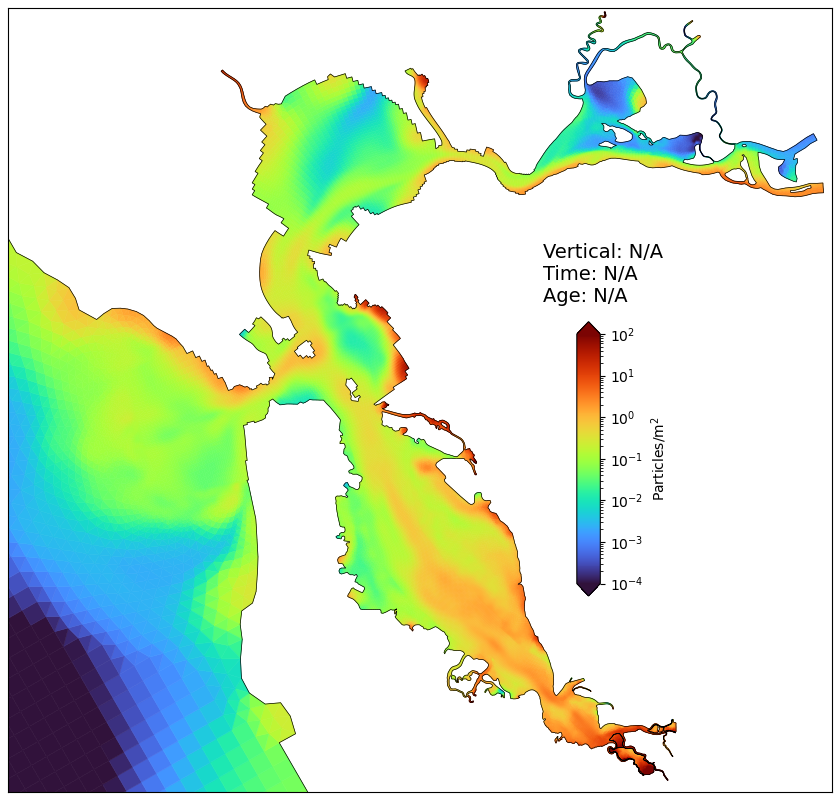

In [22]:
age=df['time'] - df['rel_time']
tau=np.timedelta64(8,'D')
decay=np.exp( -age/tau ) 

rec_DATE="2017-08-21"

# No spatial weighting, but need the godin filter weights
t_sample=np.datetime64(rec_DATE)

# Noon, local, day of sampling
t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
delta_hours=((df['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
weight_time=godwin[delta_hours+godwin_offset_h]

df['count']=weight_time * decay * df['mp_per_particle'] 

ds_conc=post.particles_to_conc(df,grid,'count')

ds_smooth=ds_conc.copy()
for _ in range(30):
    ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)

cf=conc_figure.BayConcFigure(ds_smooth,grid=grid)

In [23]:
import re

# Upstream of Richmond Br
box=(542124.018367347, 636892.818367347, 4205133.551020408, 4295389.551020408)
sel=utils.within_2d(df[ ['x0','x1']].values, box)
df_nb=df[sel].copy()

sources=[]
behaviors=[]
rel_dates=[]

grp_to_src={}
grp_to_beh={}
grp_to_rel={}

for group in df_nb['group'].unique():
    grp=os.path.basename(group)
    m=re.match(r'(.*)_([^_]+)_rel([0-9]+)_bin.out',grp)
    grp_to_src[group]=m.group(1)
    grp_to_beh[group]=m.group(2)
    grp_to_rel[group]=m.group(3)

In [24]:
df_nb['source']=df_nb['group'].map(grp_to_src)
df_nb['behavior']=df_nb['group'].map(grp_to_beh)
df_nb['rel_date']=df_nb['group'].map(grp_to_rel)

In [25]:
age=df_nb['time'] - df_nb['rel_time']
decay=np.exp( -age/tau ) 
df_nb['decay']=decay

In [26]:
# Noon, local, day of sampling
t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
delta_hours=((df_nb['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
weight_time=godwin[delta_hours+godwin_offset_h]
df_nb['weight_time']=weight_time # HERE - coming up 0.0 for some... I think that's okay.

In [27]:
# 'count' then is mp_per_particle * weight_time * decay
df_nb.groupby('source')['count'].sum().sort_values(ascending=False)

source
unnamed07             2.006024e+07
Napa_River            1.992238e+07
Suisun_Slough         1.238801e+07
Petaluma_Rive         1.229485e+07
Pacheco_Creek         1.185857e+07
Hastings_Slou         1.116995e+07
Southampton_B         7.050899e+06
Rodeo_Creek           4.271286e+06
Novato_Creek          4.071357e+06
Sonoma_Creek          3.554548e+06
Pinole_Creek          2.875867e+06
unnamed08             2.615754e+06
cccsd                 7.501748e+05
Arroyo_del_Ha         3.123878e+05
Corte_Madera_         2.928283e+05
Montezuma_Slo         2.416250e+05
Sulphur_Sprin         1.753506e+05
San_Pablo_Cre         1.672696e+05
fs                    5.516973e+04
Montezuma_Slo_1ser    4.173277e+04
Coyote_Creek_         4.578859e+03
Colma_Creek           4.113106e+03
Guadalupe_Riv         1.752032e+03
San_Leandro_C         1.525534e+03
Visitacion            1.221233e+03
Steinberger_S         1.125369e+03
src001                8.365968e+02
Guadalupe_Slo         8.121521e+02
Estudillo_Can

In [28]:
df_nb.groupby('behavior')['count'].sum().sort_values(ascending=False)

behavior
up5000       1.029845e+08
up50000      9.614679e+06
up500        9.444954e+05
down5000     5.487992e+05
down500      7.193298e+04
down50000    1.797655e+04
none         9.986020e+03
Name: count, dtype: float64

In [29]:
df_nb.columns

Index(['id', 'x0', 'x1', 'x2', 'active', 'time', 'group', 'rel_time',
       'mp_per_liter', 'm3_per_particle', 'mp_per_particle', 'cell', 'z_bed',
       'z_surface', 'age_s', 'count', 'source', 'behavior', 'rel_date',
       'decay', 'weight_time'],
      dtype='object')

<IPython.core.display.Javascript object>


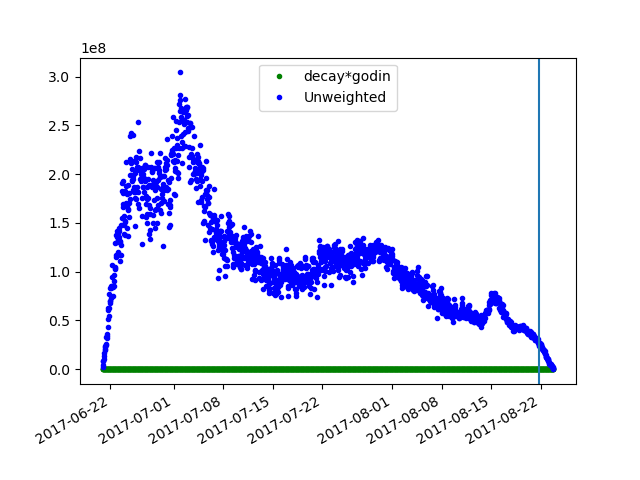

In [30]:
by_rel_time=df_nb.groupby('rel_time')['count'].sum()
fig=plt.figure()
plt.plot(by_rel_time.index.values, by_rel_time,'g.',label='decay*godin')

by_rel_time2=df_nb.groupby('rel_time')['mp_per_particle'].sum()
plt.plot(by_rel_time2.index.values, by_rel_time2, 'b.',label='Unweighted')

fig.autofmt_xdate()
plt.axvline(t_center)
plt.legend()

<IPython.core.display.Javascript object>


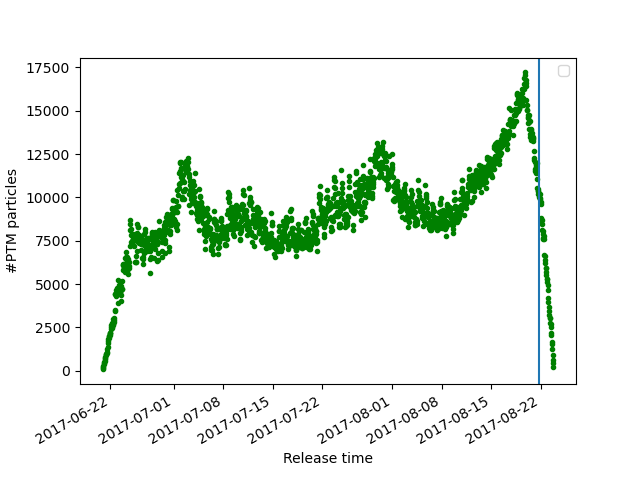

In [31]:
by_rel_time=df_nb.groupby('rel_time').size()
fig=plt.figure()
plt.plot(by_rel_time.index.values, by_rel_time,'g.')
plt.ylabel('#PTM particles')
plt.xlabel('Release time')
fig.autofmt_xdate()
plt.axvline(t_center)
plt.legend()

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


<IPython.core.display.Javascript object>


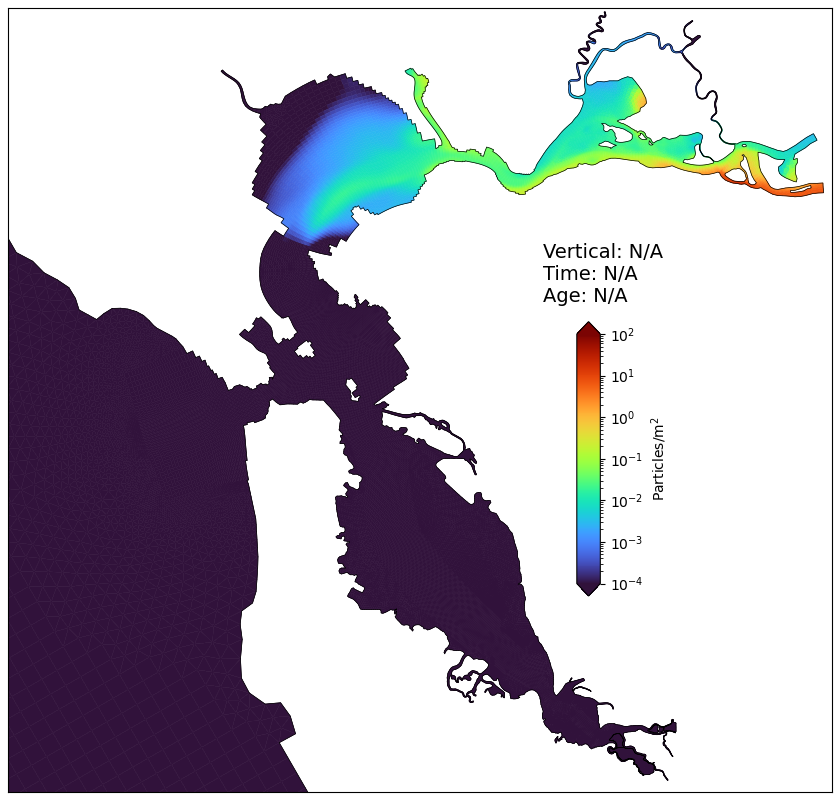

In [34]:
# What is the spatial distribution of Napa particles, ignoring their weight?
# question being, could 'fixing' Napa low discharge fix errors in Suisun 
# Bay?
# Using a mean value for mp_per_particle, there are *some* Napa particles
# in Suisun.  Enough to bump up the concentration by 10x? 

mean_mp_per_particle=df_nb['mp_per_particle'].mean()

# sort weight_time and decay to be just for the napa values.
age=df_nb['time'] - df_nb['rel_time']
tau=np.timedelta64(30,'D')
decay=np.exp( -age/tau ) 

df_nb['count']=weight_time * decay * mean_mp_per_particle 

#src_name='Napa_River'
#src_name='Suisun_Slough'
src_name='unnamed07'
sel_src=(df_nb.source==src_name).values
df_per_src=df_nb[ sel_src ]

ds_conc=post.particles_to_conc(df_per_src,grid,'count')

ds_smooth=ds_conc.copy()
for _ in range(30):
    ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)

cf=conc_figure.BayConcFigure(ds_smooth,grid=grid)

In [54]:
df_nb.source.unique()

array(['Alameda_Creek', 'Coyote_Creek_', 'Guadalupe_Riv', 'Guadalupe_Slo',
       'Montezuma_Slo', 'Napa_River', 'Pacheco_Creek', 'Petaluma_Rive',
       'San_Lorenzo_C', 'Sonoma_Creek', 'palo_alto', 'san_jose',
       'sunnyvale', 'Montezuma_Slo_1ser', 'Old_Alameda_C',
       'San_Francisqu', 'San_Leandro_C', 'San_Pablo_Cre', 'Suisun_Slough',
       'cccsd', 'fs', 'src000', 'src001', 'src002', 'unnamed07',
       'unnamed08', 'Arroyo_del_Ha', 'Colma_Creek', 'Glen_Echo_Cre',
       'Hastings_Slou', 'Matadero_and_', 'Meeker_Slough', 'Novato_Creek',
       'Permanente_Cr', 'Pinole_Creek', 'Redwood_Creek', 'Steinberger_S',
       'Stevens_Creek', 'Sulphur_Sprin', 'Corte_Madera_', 'Coyote_Point',
       'Estudillo_Can', 'Highline_Cana', 'Rodeo_Creek', 'Seal_Creek',
       'Southampton_B', 'Strawberry_Cr', 'Temescal_Cree', 'Visitacion'],
      dtype=object)

<IPython.core.display.Javascript object>


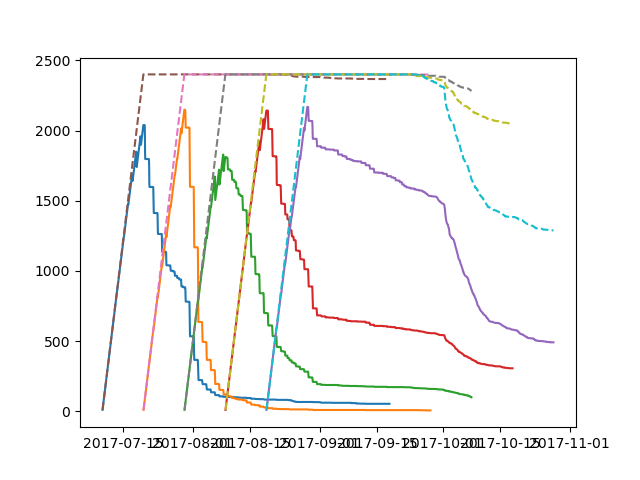

In [36]:
# Am I losing particles to the SJ boundary?  unnamed07 is a major source
# up here, and close to SJ.
from stompy.model.fish_ptm import ptm_tools
plt.figure()

for run,ls in [('022a','-'),
               ('022b','--')]:
    for ymd in ['20170710','20170720','20170730','20170809','20170819']:
        pb=ptm_tools.PtmBin(f'/opt2/sfb_ocean/ptm/all_source_{run}/chunk01/'
                            + f'{ymd}/unnamed07_up5000_rel{ymd}_bin.out')

        recs=[]
        for step in utils.progress(range(pb.count_timesteps())):
            dt,parts=pb.read_timestep(step)
            recs.append( dict(time=dt,count=len(parts)))

        df_unnamed=pd.DataFrame(recs)
        plt.plot(df_unnamed.time, df_unnamed['count'],ls=ls)
    
fig.autofmt_xdate()

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


<IPython.core.display.Javascript object>


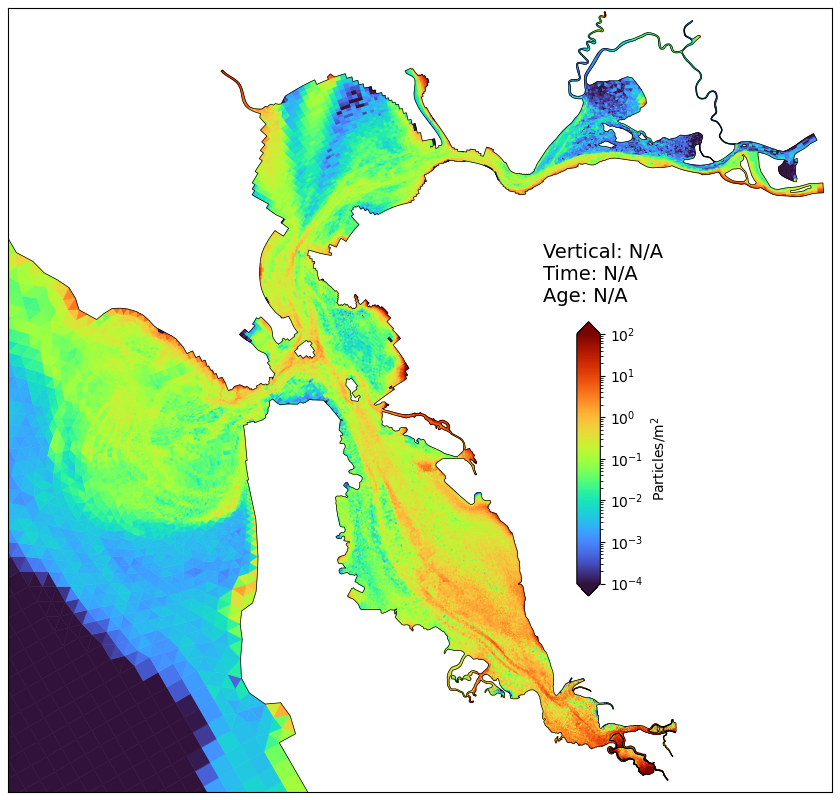

In [38]:
# Trying a more aggresive smoothing:
ds_conc=post.particles_to_conc(df,grid,'count')

cf=conc_figure.BayConcFigure(ds_conc,grid=grid)

In [56]:
Msmooth_K=grid.smooth_matrix(K=100*np.ones(grid.Nedges()))

INFO:utils:61294/99089


<IPython.core.display.Javascript object>


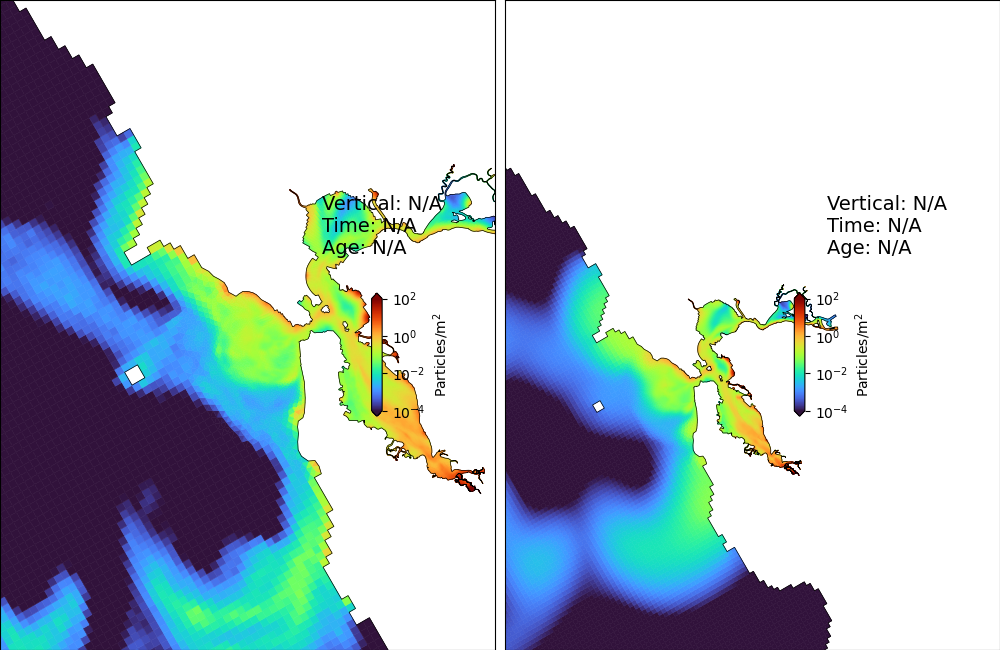

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors
INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


In [64]:
# Msmooth.dot(c) applies a single timestep of smoothing to c...
# Confirmed that implicit is working.
# Now how does the grid K vs. constant K look?
from scipy import sparse
I=sparse.eye(*Msmooth.shape)
steps=20000
Mimp_smooth=I-steps*(Msmooth_K - I)

ds_imp_smooth=ds_conc.copy()
ds_imp_smooth['conc']=('cell',), sparse.linalg.spsolve(Mimp_smooth,ds_conc['conc'])

fig,axs=plt.subplots(1,2,figsize=(10,6.5))

# Left panel - implicit diffusion, constant K
cf=conc_figure.BayConcFigure(ds_imp_smooth,grid=grid,fig=fig,ax=axs[0])

# Right panel - explicit diffusion, grid K
ds_smooth=ds_conc.copy()
c=ds_smooth['conc'].values
for _ in range(50):
    c=Msmooth.dot(c)
ds_smooth['conc']=('cell',),c
cf=conc_figure.BayConcFigure(ds_smooth,grid=grid,fig=fig,ax=axs[1])

fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.02)


In [ ]:
#ds_smooth=ds_conc.copy()
#for _ in range(30):
#    ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)
